In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [36]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
path_train = os.path.join( os.getcwd(), 'input',  'train')
path_test = os.path.join( os.getcwd(), 'input',  'test')

In [38]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "\images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_ , grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 



Done!


In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

C:\Users\785pa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


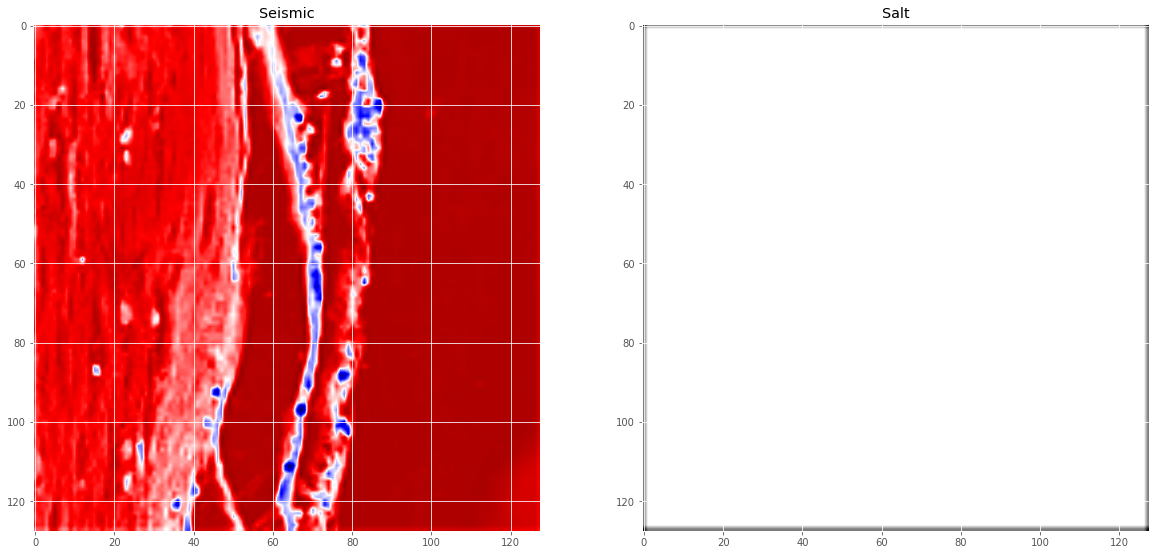

In [41]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [42]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [43]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [44]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

W0924 11:45:57.010537 23672 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0924 11:45:57.076737 23672 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0924 11:45:57.079697 23672 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0924 11:45:57.141137 23672 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0924 11:45:57.143133 23672 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 16, 16, 256)  0           conv2d_transpose_1[0][0]         
                                                                 activation_8[0][0]               
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 16, 16, 256)  0           concatenate_1[0][0]              
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 16, 16, 128)  295040      dropout_5[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 16, 16, 128)  512         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

In [45]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [46]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 439 samples, validate on 78 samples
Epoch 1/100
439/439 [==============================] - ETA: 4:45 - loss: 0.9659 - acc: 0.147 - ETA: 2:44 - loss: 0.9192 - acc: 0.172 - ETA: 2:00 - loss: 0.9080 - acc: 0.188 - ETA: 1:35 - loss: 0.8947 - acc: 0.204 - ETA: 1:18 - loss: 0.8762 - acc: 0.219 - ETA: 1:05 - loss: 0.8616 - acc: 0.255 - ETA: 53s - loss: 0.8463 - acc: 0.283 - ETA: 44s - loss: 0.8331 - acc: 0.29 - ETA: 35s - loss: 0.8246 - acc: 0.31 - ETA: 27s - loss: 0.8158 - acc: 0.33 - ETA: 19s - loss: 0.8053 - acc: 0.35 - ETA: 12s - loss: 0.7960 - acc: 0.37 - ETA: 4s - loss: 0.7889 - acc: 0.3867 - 103s 235ms/step - loss: 0.7817 - acc: 0.4003 - val_loss: 0.8970 - val_acc: 0.5845

Epoch 00001: val_loss improved from inf to 0.89700, saving model to model-tgs-salt.h5
Epoch 2/100
439/439 [==============================] - ETA: 1:10 - loss: 0.6636 - acc: 0.494 - ETA: 1:04 - loss: 0.6557 - acc: 0.550 - ETA: 58s - loss: 0.6367 - acc: 0.569 - ETA: 53s - loss: 0.6294 - acc: 0.58 - ETA: 47s - 

439/439 [==============================] - ETA: 40s - loss: 0.4208 - acc: 0.77 - ETA: 37s - loss: 0.4239 - acc: 0.78 - ETA: 34s - loss: 0.4611 - acc: 0.74 - ETA: 30s - loss: 0.4858 - acc: 0.71 - ETA: 27s - loss: 0.4877 - acc: 0.71 - ETA: 24s - loss: 0.4849 - acc: 0.71 - ETA: 21s - loss: 0.4888 - acc: 0.71 - ETA: 18s - loss: 0.4880 - acc: 0.71 - ETA: 15s - loss: 0.4958 - acc: 0.71 - ETA: 11s - loss: 0.4970 - acc: 0.71 - ETA: 8s - loss: 0.4891 - acc: 0.7229 - ETA: 5s - loss: 0.4882 - acc: 0.725 - ETA: 2s - loss: 0.4822 - acc: 0.731 - 48s 109ms/step - loss: 0.4790 - acc: 0.7343 - val_loss: 0.4678 - val_acc: 0.7480

Epoch 00012: val_loss did not improve from 0.45700
Epoch 13/100
439/439 [==============================] - ETA: 41s - loss: 0.5208 - acc: 0.70 - ETA: 38s - loss: 0.4972 - acc: 0.72 - ETA: 34s - loss: 0.4884 - acc: 0.73 - ETA: 31s - loss: 0.4663 - acc: 0.74 - ETA: 28s - loss: 0.4646 - acc: 0.74 - ETA: 24s - loss: 0.4730 - acc: 0.73 - ETA: 21s - loss: 0.4713 - acc: 0.73 - ETA: 18

439/439 [==============================] - ETA: 42s - loss: 0.4931 - acc: 0.71 - ETA: 38s - loss: 0.4222 - acc: 0.78 - ETA: 35s - loss: 0.4169 - acc: 0.78 - ETA: 32s - loss: 0.4430 - acc: 0.77 - ETA: 28s - loss: 0.4352 - acc: 0.77 - ETA: 25s - loss: 0.4338 - acc: 0.76 - ETA: 21s - loss: 0.4555 - acc: 0.74 - ETA: 18s - loss: 0.4554 - acc: 0.74 - ETA: 15s - loss: 0.4617 - acc: 0.73 - ETA: 12s - loss: 0.4668 - acc: 0.73 - ETA: 8s - loss: 0.4731 - acc: 0.7287 - ETA: 5s - loss: 0.4720 - acc: 0.732 - ETA: 2s - loss: 0.4731 - acc: 0.733 - 50s 115ms/step - loss: 0.4722 - acc: 0.7345 - val_loss: 0.4509 - val_acc: 0.7552

Epoch 00023: val_loss improved from 0.45160 to 0.45088, saving model to model-tgs-salt.h5
Epoch 24/100
439/439 [==============================] - ETA: 49s - loss: 0.4739 - acc: 0.75 - ETA: 41s - loss: 0.4495 - acc: 0.76 - ETA: 36s - loss: 0.4468 - acc: 0.76 - ETA: 33s - loss: 0.4622 - acc: 0.75 - ETA: 29s - loss: 0.4768 - acc: 0.73 - ETA: 26s - loss: 0.4893 - acc: 0.72 - ETA: 2

439/439 [==============================] - ETA: 40s - loss: 0.4523 - acc: 0.71 - ETA: 37s - loss: 0.4721 - acc: 0.71 - ETA: 34s - loss: 0.4568 - acc: 0.74 - ETA: 31s - loss: 0.4719 - acc: 0.73 - ETA: 27s - loss: 0.5038 - acc: 0.71 - ETA: 24s - loss: 0.5040 - acc: 0.71 - ETA: 21s - loss: 0.4962 - acc: 0.71 - ETA: 18s - loss: 0.4914 - acc: 0.72 - ETA: 15s - loss: 0.4805 - acc: 0.73 - ETA: 11s - loss: 0.4675 - acc: 0.74 - ETA: 8s - loss: 0.4741 - acc: 0.7370 - ETA: 5s - loss: 0.4759 - acc: 0.736 - ETA: 2s - loss: 0.4769 - acc: 0.734 - 48s 109ms/step - loss: 0.4754 - acc: 0.7344 - val_loss: 0.4500 - val_acc: 0.7552

Epoch 00034: val_loss improved from 0.45029 to 0.45002, saving model to model-tgs-salt.h5
Epoch 35/100
439/439 [==============================] - ETA: 40s - loss: 0.4478 - acc: 0.76 - ETA: 37s - loss: 0.4424 - acc: 0.75 - ETA: 34s - loss: 0.4196 - acc: 0.77 - ETA: 31s - loss: 0.3940 - acc: 0.80 - ETA: 27s - loss: 0.4249 - acc: 0.78 - ETA: 24s - loss: 0.4357 - acc: 0.76 - ETA: 2

439/439 [==============================] - ETA: 43s - loss: 0.4993 - acc: 0.70 - ETA: 39s - loss: 0.5189 - acc: 0.69 - ETA: 36s - loss: 0.5407 - acc: 0.68 - ETA: 32s - loss: 0.5132 - acc: 0.70 - ETA: 30s - loss: 0.5000 - acc: 0.71 - ETA: 26s - loss: 0.4945 - acc: 0.72 - ETA: 22s - loss: 0.4938 - acc: 0.72 - ETA: 19s - loss: 0.4797 - acc: 0.73 - ETA: 16s - loss: 0.4800 - acc: 0.73 - ETA: 12s - loss: 0.4740 - acc: 0.73 - ETA: 9s - loss: 0.4758 - acc: 0.7355 - ETA: 5s - loss: 0.4813 - acc: 0.726 - ETA: 2s - loss: 0.4772 - acc: 0.731 - 50s 115ms/step - loss: 0.4738 - acc: 0.7344 - val_loss: 0.4493 - val_acc: 0.7552

Epoch 00045: val_loss improved from 0.44933 to 0.44931, saving model to model-tgs-salt.h5
Epoch 46/100
439/439 [==============================] - ETA: 42s - loss: 0.3718 - acc: 0.84 - ETA: 39s - loss: 0.4583 - acc: 0.74 - ETA: 35s - loss: 0.4492 - acc: 0.76 - ETA: 32s - loss: 0.4577 - acc: 0.75 - ETA: 29s - loss: 0.4596 - acc: 0.74 - ETA: 25s - loss: 0.4630 - acc: 0.74 - ETA: 2

439/439 [==============================] - ETA: 43s - loss: 0.5033 - acc: 0.70 - ETA: 39s - loss: 0.5299 - acc: 0.67 - ETA: 36s - loss: 0.5515 - acc: 0.65 - ETA: 33s - loss: 0.5349 - acc: 0.67 - ETA: 29s - loss: 0.4970 - acc: 0.71 - ETA: 26s - loss: 0.5025 - acc: 0.70 - ETA: 22s - loss: 0.5089 - acc: 0.70 - ETA: 19s - loss: 0.5061 - acc: 0.70 - ETA: 16s - loss: 0.4925 - acc: 0.71 - ETA: 12s - loss: 0.4858 - acc: 0.72 - ETA: 9s - loss: 0.4774 - acc: 0.7325 - ETA: 5s - loss: 0.4726 - acc: 0.736 - ETA: 2s - loss: 0.4745 - acc: 0.733 - 51s 116ms/step - loss: 0.4731 - acc: 0.7344 - val_loss: 0.4490 - val_acc: 0.7551

Epoch 00056: val_loss improved from 0.44911 to 0.44900, saving model to model-tgs-salt.h5
Epoch 57/100
439/439 [==============================] - ETA: 42s - loss: 0.4554 - acc: 0.73 - ETA: 39s - loss: 0.4730 - acc: 0.72 - ETA: 36s - loss: 0.4900 - acc: 0.72 - ETA: 32s - loss: 0.4652 - acc: 0.74 - ETA: 29s - loss: 0.4682 - acc: 0.73 - ETA: 25s - loss: 0.4772 - acc: 0.73 - ETA: 2

439/439 [==============================] - ETA: 43s - loss: 0.6507 - acc: 0.56 - ETA: 40s - loss: 0.5266 - acc: 0.68 - ETA: 36s - loss: 0.5123 - acc: 0.69 - ETA: 33s - loss: 0.4890 - acc: 0.71 - ETA: 29s - loss: 0.4916 - acc: 0.71 - ETA: 26s - loss: 0.4992 - acc: 0.70 - ETA: 23s - loss: 0.4922 - acc: 0.71 - ETA: 19s - loss: 0.4929 - acc: 0.70 - ETA: 16s - loss: 0.4883 - acc: 0.71 - ETA: 13s - loss: 0.4869 - acc: 0.71 - ETA: 9s - loss: 0.4891 - acc: 0.7189 - ETA: 6s - loss: 0.4771 - acc: 0.730 - ETA: 2s - loss: 0.4794 - acc: 0.730 - 55s 124ms/step - loss: 0.4748 - acc: 0.7344 - val_loss: 0.4488 - val_acc: 0.7551

Epoch 00067: val_loss did not improve from 0.44872
Epoch 68/100
439/439 [==============================] - ETA: 44s - loss: 0.5730 - acc: 0.64 - ETA: 41s - loss: 0.4853 - acc: 0.73 - ETA: 37s - loss: 0.4819 - acc: 0.73 - ETA: 34s - loss: 0.4617 - acc: 0.74 - ETA: 30s - loss: 0.4541 - acc: 0.75 - ETA: 26s - loss: 0.4466 - acc: 0.75 - ETA: 23s - loss: 0.4496 - acc: 0.74 - ETA: 19

439/439 [==============================] - ETA: 43s - loss: 0.5074 - acc: 0.67 - ETA: 39s - loss: 0.5497 - acc: 0.64 - ETA: 36s - loss: 0.5400 - acc: 0.66 - ETA: 33s - loss: 0.5293 - acc: 0.67 - ETA: 30s - loss: 0.5070 - acc: 0.69 - ETA: 26s - loss: 0.5007 - acc: 0.70 - ETA: 23s - loss: 0.4950 - acc: 0.71 - ETA: 19s - loss: 0.4911 - acc: 0.71 - ETA: 16s - loss: 0.4752 - acc: 0.72 - ETA: 13s - loss: 0.4704 - acc: 0.73 - ETA: 9s - loss: 0.4766 - acc: 0.7271 - ETA: 6s - loss: 0.4798 - acc: 0.724 - ETA: 2s - loss: 0.4776 - acc: 0.726 - 53s 121ms/step - loss: 0.4702 - acc: 0.7344 - val_loss: 0.4485 - val_acc: 0.7552

Epoch 00078: val_loss improved from 0.44849 to 0.44845, saving model to model-tgs-salt.h5
Epoch 79/100
439/439 [==============================] - ETA: 45s - loss: 0.4050 - acc: 0.79 - ETA: 40s - loss: 0.4434 - acc: 0.76 - ETA: 37s - loss: 0.4377 - acc: 0.77 - ETA: 33s - loss: 0.4411 - acc: 0.76 - ETA: 30s - loss: 0.4499 - acc: 0.74 - ETA: 26s - loss: 0.4483 - acc: 0.74 - ETA: 2

439/439 [==============================] - ETA: 44s - loss: 0.4397 - acc: 0.75 - ETA: 41s - loss: 0.4455 - acc: 0.75 - ETA: 37s - loss: 0.4514 - acc: 0.74 - ETA: 33s - loss: 0.4784 - acc: 0.72 - ETA: 30s - loss: 0.4783 - acc: 0.72 - ETA: 26s - loss: 0.4660 - acc: 0.73 - ETA: 23s - loss: 0.4692 - acc: 0.73 - ETA: 19s - loss: 0.4556 - acc: 0.74 - ETA: 16s - loss: 0.4645 - acc: 0.73 - ETA: 13s - loss: 0.4779 - acc: 0.72 - ETA: 9s - loss: 0.4688 - acc: 0.7347 - ETA: 6s - loss: 0.4665 - acc: 0.737 - ETA: 2s - loss: 0.4692 - acc: 0.736 - 53s 120ms/step - loss: 0.4727 - acc: 0.7345 - val_loss: 0.4481 - val_acc: 0.7552

Epoch 00089: val_loss improved from 0.44812 to 0.44810, saving model to model-tgs-salt.h5
Epoch 90/100
439/439 [==============================] - ETA: 43s - loss: 0.3792 - acc: 0.83 - ETA: 40s - loss: 0.4520 - acc: 0.75 - ETA: 37s - loss: 0.4736 - acc: 0.73 - ETA: 33s - loss: 0.4697 - acc: 0.73 - ETA: 30s - loss: 0.4703 - acc: 0.73 - ETA: 26s - loss: 0.4692 - acc: 0.73 - ETA: 2

439/439 [==============================] - ETA: 48s - loss: 0.4277 - acc: 0.77 - ETA: 42s - loss: 0.4105 - acc: 0.78 - ETA: 39s - loss: 0.4325 - acc: 0.77 - ETA: 44s - loss: 0.4414 - acc: 0.75 - ETA: 42s - loss: 0.4503 - acc: 0.75 - ETA: 39s - loss: 0.4510 - acc: 0.75 - ETA: 34s - loss: 0.4614 - acc: 0.74 - ETA: 30s - loss: 0.4859 - acc: 0.72 - ETA: 25s - loss: 0.4834 - acc: 0.72 - ETA: 19s - loss: 0.4717 - acc: 0.73 - ETA: 14s - loss: 0.4670 - acc: 0.73 - ETA: 9s - loss: 0.4716 - acc: 0.7339 - ETA: 3s - loss: 0.4775 - acc: 0.726 - 82s 186ms/step - loss: 0.4702 - acc: 0.7344 - val_loss: 0.4478 - val_acc: 0.7552

Epoch 00100: val_loss did not improve from 0.44775


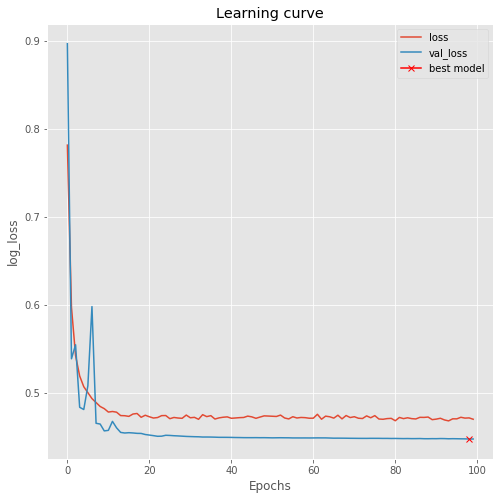

In [47]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [48]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [49]:
model.evaluate(X_valid, y_valid, verbose=1)

78/78 [==============================] - ETA:  - ETA:  - 7s 88ms/step


[0.4477488704216786, 0.7551613786281683]

In [50]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

78/78 [==============================] - ETA:  - ETA:  - 7s 90ms/step


In [51]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

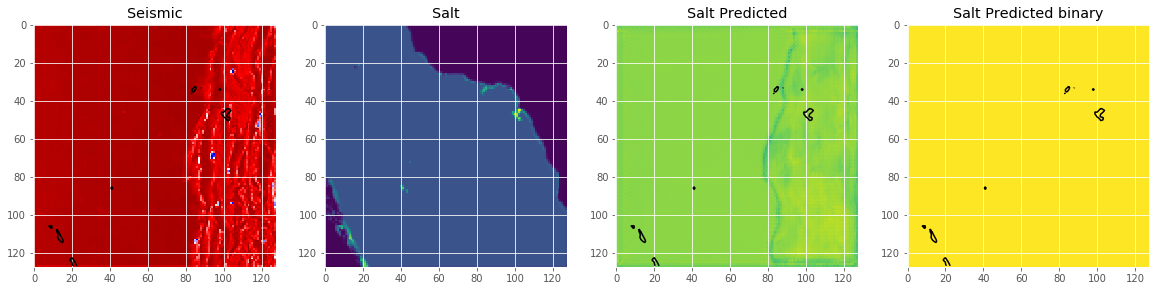

In [52]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

C:\Users\785pa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\785pa\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.
C:\Users\785pa\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


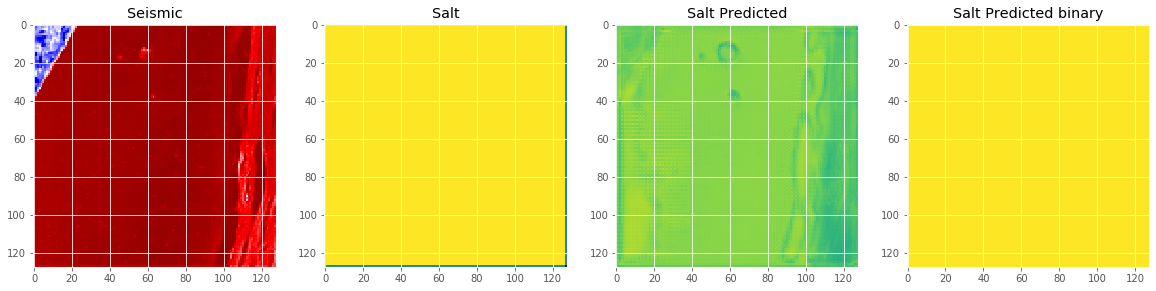

In [53]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)